# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć neuronowa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import np_utils

### Ustawienia

In [2]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [3]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
# image_size = (100, 100)
image_size = (64, 64)
# image_size = (32, 32)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [4]:
def generator_to_array(data_generator):
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        data_list.append(data[0])
        batch_index = batch_index + 1

    data_array = np.asarray(data_list, dtype=object)
    X = np.concatenate(data_array, axis=0)
    y = data_generator.classes
    y = np_utils.to_categorical(y)
    return (X, y)

In [5]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [6]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [34]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = ['Oponiak', 'Glejak', 'Guz przysadki']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)
    
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_ax = plt.subplots(1, 1, figsize = (10, 6))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [60]:
train_generator = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=(0.8, 1.5),
)

def get_train_generator():
    return train_generator.flow_from_directory(
            train_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)

train_data_generator = get_train_generator()
train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)

Found 480 images belonging to 3 classes.


In [9]:
test_generator = ImageDataGenerator()

def get_test_generator():
    return test_generator.flow_from_directory(
            val_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)

test_data_generator = get_test_generator()
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 120 images belonging to 3 classes.


### Próbka zbioru treningowego

Found 480 images belonging to 3 classes.


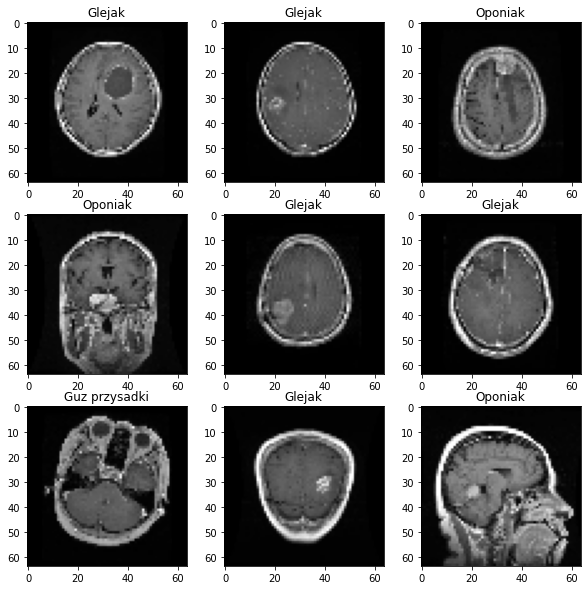

In [10]:
plt.figure(figsize=(10, 10))

b = next(train_data_generator)

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"), cmap='gray')
    label = cancer_type[np.argmax(label)]
    plt.title(label)
    
train_data_generator = get_train_generator()

## Model

In [49]:
def build_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=image_size + (3,)))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Flatten())
    
    model.add(Dense(300,activation="relu"))
    model.add(Dense(100,activation="relu"))
    model.add(Dense(50,activation="relu"))
#     model.add(Dense(10,activation="relu"))
    model.add(Dense(3,activation="softmax"))
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=[
            "categorical_accuracy",
            "accuracy",
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
        ],
    )

    return model

In [61]:
model = build_model()
history = History()

In [62]:
build_model().summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 300)               3686700   
_________________________________________________________________
dense_38 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 153       
Total params: 3,722,003
Trainable params: 3,722,003
Non-trainable params: 0
____________________________________________

In [63]:
epochs = 200

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1),
    history
]

model.fit(
    get_train_generator(),
    validation_data=get_test_generator(), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=callbacks,
)


Found 480 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Epoch 1/200
15/15 [==============================] - 6s 151ms/step - loss: 1.1344 - categorical_accuracy: 0.5188 - accuracy: 0.5188 - precision: 0.5772 - recall: 0.4437 - auc: 0.6962 - val_loss: 0.8720 - val_categorical_accuracy: 0.5417 - val_accuracy: 0.5417 - val_precision: 0.6471 - val_recall: 0.4583 - val_auc: 0.7810
Epoch 2/200
15/15 [==============================] - 1s 88ms/step - loss: 0.6911 - categorical_accuracy: 0.6708 - accuracy: 0.6708 - precision: 0.7340 - recall: 0.5750 - auc: 0.8610 - val_loss: 0.7329 - val_categorical_accuracy: 0.6250 - val_accuracy: 0.6250 - val_precision: 0.6604 - val_recall: 0.5833 - val_auc: 0.8442
Epoch 3/200
15/15 [==============================] - 1s 89ms/step - loss: 0.5727 - categorical_accuracy: 0.7354 - accuracy: 0.7354 - precision: 0.7590 - recall: 0.7021 - auc: 0.9046 - val_loss: 0.6792 - val_categorical_accuracy: 0.6667 - val_accuracy: 0.6667 - val_precisio

15/15 [==============================] - 2s 106ms/step - loss: 0.0114 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.1371 - val_categorical_accuracy: 0.7667 - val_accuracy: 0.7667 - val_precision: 0.7647 - val_recall: 0.7583 - val_auc: 0.8894
Epoch 27/200
15/15 [==============================] - 1s 95ms/step - loss: 0.0085 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.1728 - val_categorical_accuracy: 0.7500 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8870
Epoch 28/200
15/15 [==============================] - 1s 89ms/step - loss: 0.0096 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.2614 - val_categorical_accuracy: 0.7833 - val_accuracy: 0.7833 - val_precision: 0.7815 - val_recall: 0.7750 - val_auc: 0.8715
Epoch 29/200
15/15 [=======================

15/15 [==============================] - 1s 96ms/step - loss: 3.4207e-04 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5383 - val_categorical_accuracy: 0.7500 - val_accuracy: 0.7500 - val_precision: 0.7563 - val_recall: 0.7500 - val_auc: 0.8606
Epoch 52/200
15/15 [==============================] - 1s 98ms/step - loss: 3.1275e-04 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5500 - val_categorical_accuracy: 0.7500 - val_accuracy: 0.7500 - val_precision: 0.7563 - val_recall: 0.7500 - val_auc: 0.8611
Epoch 53/200
15/15 [==============================] - 1s 91ms/step - loss: 2.9309e-04 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5657 - val_categorical_accuracy: 0.7417 - val_accuracy: 0.7417 - val_precision: 0.7479 - val_recall: 0.7417 - val_auc: 0.8613
Epoch 54/200
15/15 [============

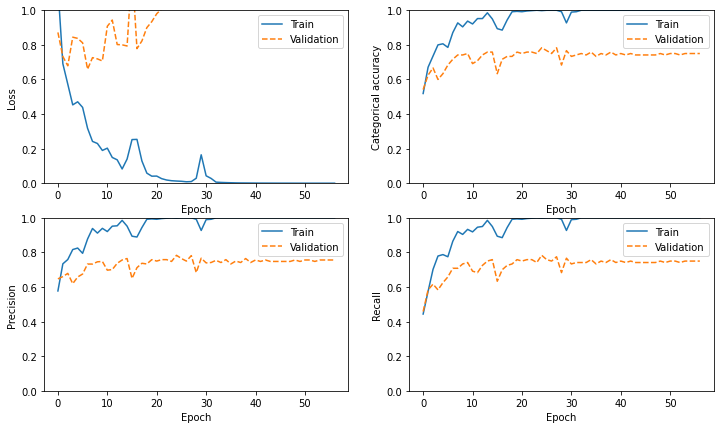

In [73]:
plot_metrics(history)

In [69]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [70]:
import sklearn.metrics
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.68      0.68      0.68        40
           2       0.66      0.62      0.64        40
           3       0.90      0.95      0.93        40

    accuracy                           0.75       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.75      0.75      0.75       120



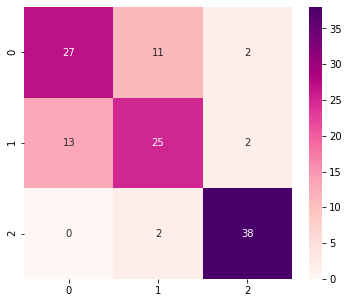

In [71]:
plot_confusion_matrix(predicted_classes, true_classes)

ROC AUC score: 0.8830729166666668


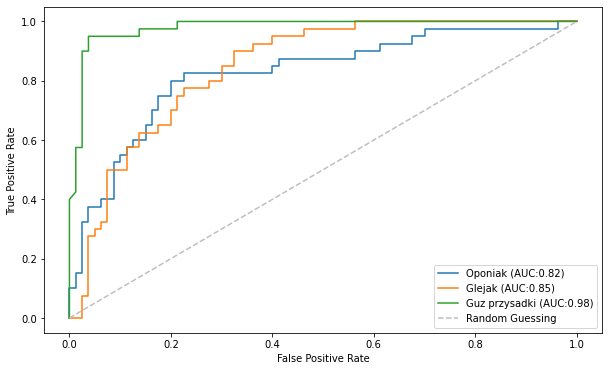

In [72]:
plot_roc_curve(true_classes, predictions)

In [58]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [59]:
img = keras.preprocessing.image.load_img(
    "data/val/3/15.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

p = model.predict_proba(img_array)
score = p[0]
print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)

C:\Users\Hubert\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[2.9248941e-08 3.1298405e-05 9.9996865e-01]
Oponiak : 0.00%
Glejak : 0.00%
Guz przysadki : 100.00%
